# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

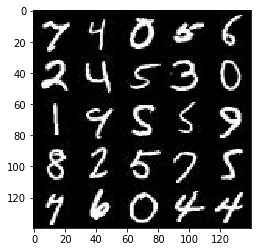

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

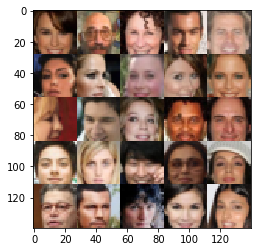

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_images = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return (input_images, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1

    with tf.variable_scope("discriminator", reuse=reuse):

        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        normalization2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha*normalization2, normalization2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding="same")
        normalization3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha*normalization3, normalization3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1

    with tf.variable_scope("generator", reuse= not is_train):

        fullyConLayer = tf.layers.dense(z, 7*7*256)
        
        fullyConLayer = tf.reshape(fullyConLayer, (-1, 7, 7, 256))
        normalization1 = tf.layers.batch_normalization(fullyConLayer, training=is_train)
        relu1 = tf.maximum(alpha*normalization1, normalization1)
        
        conv2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding="same")
        normalization2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha*normalization2, normalization2)
        
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding="same")
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs( data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2.0
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,25, input_z, data_shape[3], data_image_mode)

    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 4.0105... Generator Loss: 0.1931
Epoch 0/2... Discriminator Loss: 2.8856... Generator Loss: 0.2155
Epoch 0/2... Discriminator Loss: 1.0537... Generator Loss: 2.1550
Epoch 0/2... Discriminator Loss: 0.6705... Generator Loss: 1.5300
Epoch 0/2... Discriminator Loss: 0.3523... Generator Loss: 2.7709
Epoch 0/2... Discriminator Loss: 0.2822... Generator Loss: 2.0953
Epoch 0/2... Discriminator Loss: 1.3810... Generator Loss: 0.5735
Epoch 0/2... Discriminator Loss: 1.1237... Generator Loss: 1.2902
Epoch 0/2... Discriminator Loss: 0.8157... Generator Loss: 1.2463
Epoch 0/2... Discriminator Loss: 1.4766... Generator Loss: 0.5725


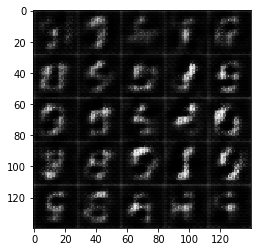

Epoch 0/2... Discriminator Loss: 1.0137... Generator Loss: 0.7615
Epoch 0/2... Discriminator Loss: 1.9901... Generator Loss: 0.2068
Epoch 0/2... Discriminator Loss: 0.8060... Generator Loss: 1.3625
Epoch 0/2... Discriminator Loss: 2.0023... Generator Loss: 0.2721
Epoch 0/2... Discriminator Loss: 0.7063... Generator Loss: 1.4402
Epoch 0/2... Discriminator Loss: 2.1843... Generator Loss: 2.1868
Epoch 0/2... Discriminator Loss: 1.0340... Generator Loss: 1.3009
Epoch 0/2... Discriminator Loss: 1.1408... Generator Loss: 0.7099
Epoch 0/2... Discriminator Loss: 0.9378... Generator Loss: 1.3590
Epoch 0/2... Discriminator Loss: 1.2105... Generator Loss: 0.5905


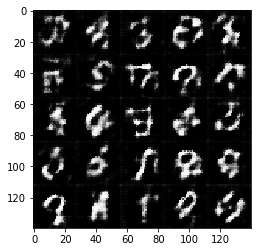

Epoch 0/2... Discriminator Loss: 1.1010... Generator Loss: 0.8942
Epoch 0/2... Discriminator Loss: 1.1151... Generator Loss: 1.5581
Epoch 0/2... Discriminator Loss: 0.9871... Generator Loss: 0.8345
Epoch 0/2... Discriminator Loss: 1.3169... Generator Loss: 1.3263
Epoch 0/2... Discriminator Loss: 1.1987... Generator Loss: 0.5338
Epoch 0/2... Discriminator Loss: 1.3296... Generator Loss: 0.6082
Epoch 0/2... Discriminator Loss: 1.9476... Generator Loss: 0.2405
Epoch 0/2... Discriminator Loss: 1.1363... Generator Loss: 0.9597
Epoch 0/2... Discriminator Loss: 1.1142... Generator Loss: 0.9296
Epoch 0/2... Discriminator Loss: 1.0291... Generator Loss: 1.0359


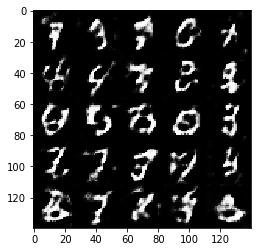

Epoch 0/2... Discriminator Loss: 0.9743... Generator Loss: 0.9009
Epoch 0/2... Discriminator Loss: 0.8933... Generator Loss: 0.8580
Epoch 0/2... Discriminator Loss: 0.9643... Generator Loss: 0.8852
Epoch 0/2... Discriminator Loss: 1.3116... Generator Loss: 0.5221
Epoch 0/2... Discriminator Loss: 1.7297... Generator Loss: 0.3400
Epoch 0/2... Discriminator Loss: 0.8203... Generator Loss: 0.9478
Epoch 0/2... Discriminator Loss: 1.2368... Generator Loss: 0.5768
Epoch 0/2... Discriminator Loss: 1.0594... Generator Loss: 0.7835
Epoch 0/2... Discriminator Loss: 1.1312... Generator Loss: 0.6756
Epoch 0/2... Discriminator Loss: 1.0120... Generator Loss: 1.3988


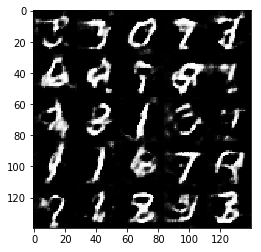

Epoch 0/2... Discriminator Loss: 1.1842... Generator Loss: 0.8832
Epoch 0/2... Discriminator Loss: 0.9393... Generator Loss: 0.9164
Epoch 0/2... Discriminator Loss: 1.3791... Generator Loss: 0.4455
Epoch 0/2... Discriminator Loss: 1.6412... Generator Loss: 0.3107
Epoch 0/2... Discriminator Loss: 1.1280... Generator Loss: 1.2165
Epoch 0/2... Discriminator Loss: 0.9785... Generator Loss: 0.8720
Epoch 0/2... Discriminator Loss: 1.0795... Generator Loss: 0.8517
Epoch 0/2... Discriminator Loss: 1.1778... Generator Loss: 0.9836
Epoch 0/2... Discriminator Loss: 0.9785... Generator Loss: 0.8082
Epoch 0/2... Discriminator Loss: 1.3703... Generator Loss: 0.4570


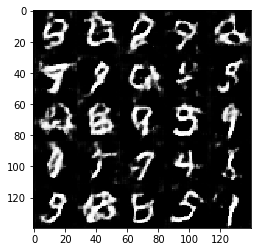

Epoch 0/2... Discriminator Loss: 1.1308... Generator Loss: 1.5171
Epoch 0/2... Discriminator Loss: 0.9070... Generator Loss: 1.0680
Epoch 0/2... Discriminator Loss: 0.8826... Generator Loss: 1.6877
Epoch 0/2... Discriminator Loss: 0.8077... Generator Loss: 1.1098
Epoch 0/2... Discriminator Loss: 1.2827... Generator Loss: 0.4440
Epoch 0/2... Discriminator Loss: 0.9521... Generator Loss: 0.9270
Epoch 0/2... Discriminator Loss: 1.4437... Generator Loss: 0.3593
Epoch 0/2... Discriminator Loss: 1.6401... Generator Loss: 0.2830
Epoch 0/2... Discriminator Loss: 1.0451... Generator Loss: 1.0100
Epoch 0/2... Discriminator Loss: 1.0419... Generator Loss: 0.8933


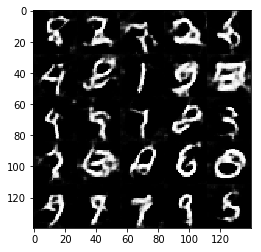

Epoch 0/2... Discriminator Loss: 1.4976... Generator Loss: 0.3225
Epoch 0/2... Discriminator Loss: 1.1662... Generator Loss: 0.5619
Epoch 0/2... Discriminator Loss: 1.1512... Generator Loss: 0.8906
Epoch 0/2... Discriminator Loss: 0.8356... Generator Loss: 1.0940
Epoch 0/2... Discriminator Loss: 1.2552... Generator Loss: 0.4973
Epoch 0/2... Discriminator Loss: 1.0564... Generator Loss: 0.9069
Epoch 0/2... Discriminator Loss: 1.4317... Generator Loss: 0.3747
Epoch 0/2... Discriminator Loss: 0.8918... Generator Loss: 1.3116
Epoch 0/2... Discriminator Loss: 0.9236... Generator Loss: 0.9298
Epoch 0/2... Discriminator Loss: 0.9281... Generator Loss: 1.6466


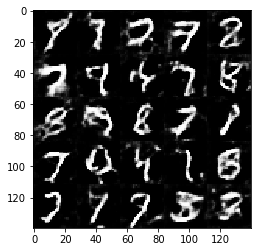

Epoch 0/2... Discriminator Loss: 1.0949... Generator Loss: 0.6881
Epoch 0/2... Discriminator Loss: 1.0938... Generator Loss: 0.7000
Epoch 0/2... Discriminator Loss: 1.3862... Generator Loss: 0.4478
Epoch 0/2... Discriminator Loss: 0.9383... Generator Loss: 0.9120
Epoch 0/2... Discriminator Loss: 1.0250... Generator Loss: 1.1843
Epoch 0/2... Discriminator Loss: 1.2473... Generator Loss: 0.4986
Epoch 0/2... Discriminator Loss: 1.2852... Generator Loss: 2.6373
Epoch 0/2... Discriminator Loss: 1.0079... Generator Loss: 0.8518
Epoch 0/2... Discriminator Loss: 1.1865... Generator Loss: 0.6734
Epoch 0/2... Discriminator Loss: 1.6872... Generator Loss: 0.2835


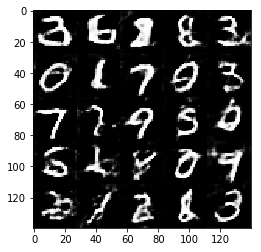

Epoch 0/2... Discriminator Loss: 1.0319... Generator Loss: 0.6946
Epoch 0/2... Discriminator Loss: 1.0653... Generator Loss: 0.6828
Epoch 0/2... Discriminator Loss: 1.0206... Generator Loss: 0.7033
Epoch 0/2... Discriminator Loss: 0.8784... Generator Loss: 0.9716
Epoch 0/2... Discriminator Loss: 1.0464... Generator Loss: 0.6297
Epoch 0/2... Discriminator Loss: 0.9044... Generator Loss: 0.9198
Epoch 0/2... Discriminator Loss: 0.8966... Generator Loss: 0.8780
Epoch 0/2... Discriminator Loss: 0.9384... Generator Loss: 1.0390
Epoch 0/2... Discriminator Loss: 0.9225... Generator Loss: 0.9329
Epoch 0/2... Discriminator Loss: 0.8486... Generator Loss: 1.4956


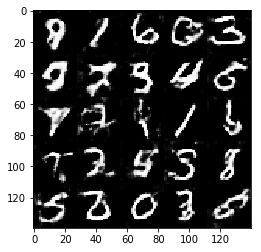

Epoch 0/2... Discriminator Loss: 1.3294... Generator Loss: 0.4223
Epoch 0/2... Discriminator Loss: 1.6481... Generator Loss: 0.5516
Epoch 0/2... Discriminator Loss: 1.1329... Generator Loss: 0.5828
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 1.6370
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 0.6259
Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 1.2182
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 1.3824
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 2.6790
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.9354


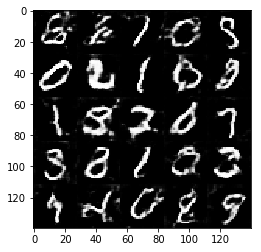

Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.4189
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.5720
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 1.9797
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.5131
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 0.4759
Epoch 1/2... Discriminator Loss: 2.0733... Generator Loss: 0.1926
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 1.1957
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.6928
Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 0.8573


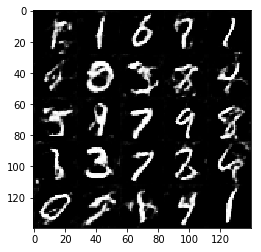

Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 2.3076
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 0.7499... Generator Loss: 1.0736
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 1.6791
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.5730
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 0.7051
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 0.7047


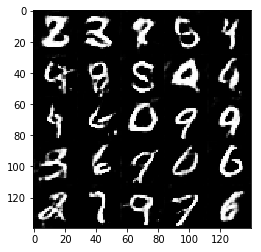

Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.8960... Generator Loss: 2.7308
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 1.0413
Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.5219
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 0.8795
Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 1.0252
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 1.2910
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 2.3919


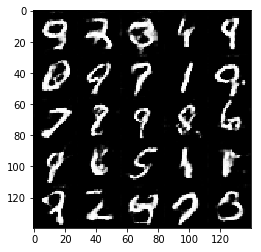

Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.4751
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.3424
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.7246
Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 0.6749... Generator Loss: 1.1945
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 0.5855
Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 1.4444
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.6156


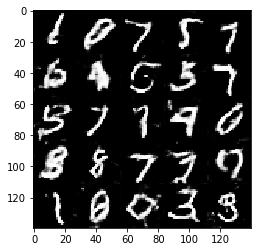

Epoch 1/2... Discriminator Loss: 1.5120... Generator Loss: 0.4070
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 0.8632
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 0.8040
Epoch 1/2... Discriminator Loss: 0.7112... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.7576
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.6744
Epoch 1/2... Discriminator Loss: 3.1343... Generator Loss: 3.1497
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 0.7563


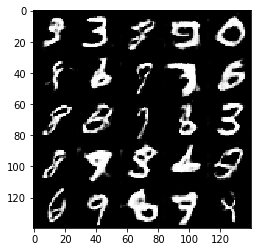

Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 0.9458... Generator Loss: 1.6555
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 0.8714... Generator Loss: 0.8922
Epoch 1/2... Discriminator Loss: 0.7599... Generator Loss: 1.1880
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 0.9649
Epoch 1/2... Discriminator Loss: 4.1595... Generator Loss: 4.2539
Epoch 1/2... Discriminator Loss: 0.9098... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 1.0132
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 1.3638


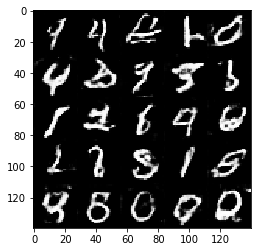

Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.6021
Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 1.6570... Generator Loss: 0.3301
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 0.7647
Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 1.2042
Epoch 1/2... Discriminator Loss: 1.7481... Generator Loss: 0.3019
Epoch 1/2... Discriminator Loss: 2.0234... Generator Loss: 0.2270


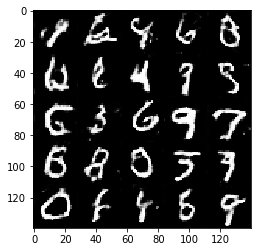

Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 0.5643
Epoch 1/2... Discriminator Loss: 0.7825... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 1.6791
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.8248
Epoch 1/2... Discriminator Loss: 0.8514... Generator Loss: 0.9120


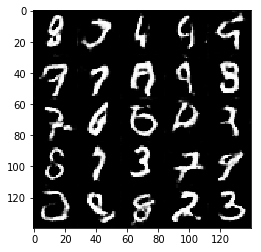

Epoch 1/2... Discriminator Loss: 3.7022... Generator Loss: 0.0576
Epoch 1/2... Discriminator Loss: 0.7875... Generator Loss: 1.0764
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 1.1665
Epoch 1/2... Discriminator Loss: 0.7356... Generator Loss: 1.4122
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 0.8081... Generator Loss: 0.9811
Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 1.3374


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.4182... Generator Loss: 1.6849
Epoch 0/1... Discriminator Loss: 0.4330... Generator Loss: 1.4293
Epoch 0/1... Discriminator Loss: 0.1390... Generator Loss: 2.9673
Epoch 0/1... Discriminator Loss: 0.1580... Generator Loss: 2.5759
Epoch 0/1... Discriminator Loss: 0.1004... Generator Loss: 3.0560
Epoch 0/1... Discriminator Loss: 0.2216... Generator Loss: 2.1502
Epoch 0/1... Discriminator Loss: 0.1099... Generator Loss: 2.6861
Epoch 0/1... Discriminator Loss: 0.2026... Generator Loss: 4.3177
Epoch 0/1... Discriminator Loss: 0.8131... Generator Loss: 5.1495
Epoch 0/1... Discriminator Loss: 0.7186... Generator Loss: 0.9512


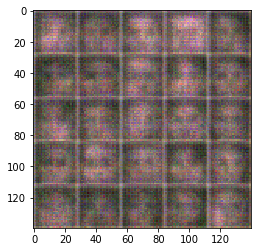

Epoch 0/1... Discriminator Loss: 0.3638... Generator Loss: 2.1717
Epoch 0/1... Discriminator Loss: 0.7075... Generator Loss: 1.3603
Epoch 0/1... Discriminator Loss: 1.4434... Generator Loss: 3.8997
Epoch 0/1... Discriminator Loss: 0.4766... Generator Loss: 1.9981
Epoch 0/1... Discriminator Loss: 0.8202... Generator Loss: 0.9077
Epoch 0/1... Discriminator Loss: 0.7302... Generator Loss: 2.6940
Epoch 0/1... Discriminator Loss: 0.6283... Generator Loss: 1.2318
Epoch 0/1... Discriminator Loss: 0.6427... Generator Loss: 1.1872
Epoch 0/1... Discriminator Loss: 0.7090... Generator Loss: 1.9417
Epoch 0/1... Discriminator Loss: 0.7996... Generator Loss: 2.7014


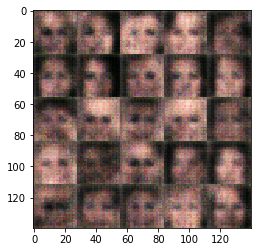

Epoch 0/1... Discriminator Loss: 0.6819... Generator Loss: 2.0348
Epoch 0/1... Discriminator Loss: 0.6560... Generator Loss: 1.7445
Epoch 0/1... Discriminator Loss: 0.9387... Generator Loss: 1.5545
Epoch 0/1... Discriminator Loss: 0.7549... Generator Loss: 1.6032
Epoch 0/1... Discriminator Loss: 0.6198... Generator Loss: 1.2206
Epoch 0/1... Discriminator Loss: 0.5035... Generator Loss: 2.0811
Epoch 0/1... Discriminator Loss: 0.4860... Generator Loss: 1.7180
Epoch 0/1... Discriminator Loss: 0.8459... Generator Loss: 1.1374
Epoch 0/1... Discriminator Loss: 0.8079... Generator Loss: 1.4568
Epoch 0/1... Discriminator Loss: 0.4664... Generator Loss: 1.5348


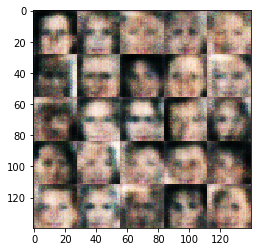

Epoch 0/1... Discriminator Loss: 0.6025... Generator Loss: 1.9700
Epoch 0/1... Discriminator Loss: 0.9610... Generator Loss: 0.8632
Epoch 0/1... Discriminator Loss: 0.9591... Generator Loss: 0.8252
Epoch 0/1... Discriminator Loss: 0.7740... Generator Loss: 1.0370
Epoch 0/1... Discriminator Loss: 0.8359... Generator Loss: 0.9087
Epoch 0/1... Discriminator Loss: 0.7611... Generator Loss: 1.4140
Epoch 0/1... Discriminator Loss: 0.7642... Generator Loss: 1.5424
Epoch 0/1... Discriminator Loss: 0.7433... Generator Loss: 1.3374
Epoch 0/1... Discriminator Loss: 0.7802... Generator Loss: 1.4560
Epoch 0/1... Discriminator Loss: 1.1025... Generator Loss: 2.2556


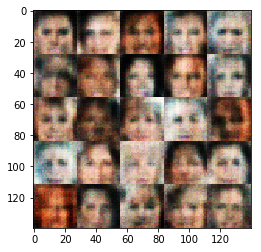

Epoch 0/1... Discriminator Loss: 0.7266... Generator Loss: 1.3870
Epoch 0/1... Discriminator Loss: 0.7692... Generator Loss: 0.9617
Epoch 0/1... Discriminator Loss: 0.7730... Generator Loss: 1.0517
Epoch 0/1... Discriminator Loss: 0.8332... Generator Loss: 1.5395
Epoch 0/1... Discriminator Loss: 0.7485... Generator Loss: 1.0780
Epoch 0/1... Discriminator Loss: 0.8088... Generator Loss: 1.1893
Epoch 0/1... Discriminator Loss: 0.7803... Generator Loss: 1.1547
Epoch 0/1... Discriminator Loss: 0.5742... Generator Loss: 1.4823
Epoch 0/1... Discriminator Loss: 0.7664... Generator Loss: 1.0624
Epoch 0/1... Discriminator Loss: 0.7058... Generator Loss: 1.2978


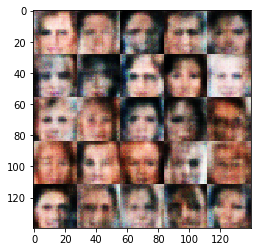

Epoch 0/1... Discriminator Loss: 0.8777... Generator Loss: 1.8150
Epoch 0/1... Discriminator Loss: 0.5947... Generator Loss: 1.5591
Epoch 0/1... Discriminator Loss: 0.6675... Generator Loss: 1.1831
Epoch 0/1... Discriminator Loss: 0.6264... Generator Loss: 1.5093
Epoch 0/1... Discriminator Loss: 0.8850... Generator Loss: 0.7732
Epoch 0/1... Discriminator Loss: 0.6844... Generator Loss: 1.4918
Epoch 0/1... Discriminator Loss: 0.7203... Generator Loss: 1.1068
Epoch 0/1... Discriminator Loss: 0.6988... Generator Loss: 2.5680
Epoch 0/1... Discriminator Loss: 0.6362... Generator Loss: 1.4691
Epoch 0/1... Discriminator Loss: 0.6629... Generator Loss: 1.2891


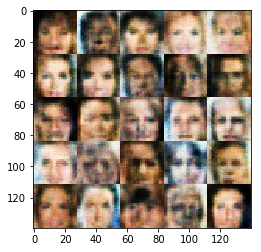

Epoch 0/1... Discriminator Loss: 1.1807... Generator Loss: 0.5567
Epoch 0/1... Discriminator Loss: 0.7009... Generator Loss: 1.0594
Epoch 0/1... Discriminator Loss: 0.6388... Generator Loss: 1.3768
Epoch 0/1... Discriminator Loss: 0.7261... Generator Loss: 2.0339
Epoch 0/1... Discriminator Loss: 0.5780... Generator Loss: 1.5304
Epoch 0/1... Discriminator Loss: 0.6227... Generator Loss: 1.4366
Epoch 0/1... Discriminator Loss: 0.7866... Generator Loss: 1.4361
Epoch 0/1... Discriminator Loss: 0.4960... Generator Loss: 1.9717
Epoch 0/1... Discriminator Loss: 0.7142... Generator Loss: 1.8127
Epoch 0/1... Discriminator Loss: 0.6700... Generator Loss: 3.0043


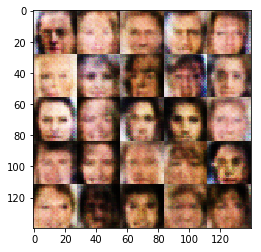

Epoch 0/1... Discriminator Loss: 0.8147... Generator Loss: 1.0791
Epoch 0/1... Discriminator Loss: 0.6689... Generator Loss: 1.0861
Epoch 0/1... Discriminator Loss: 0.9113... Generator Loss: 1.2117
Epoch 0/1... Discriminator Loss: 1.0536... Generator Loss: 0.8101
Epoch 0/1... Discriminator Loss: 1.0123... Generator Loss: 0.7429
Epoch 0/1... Discriminator Loss: 0.8782... Generator Loss: 1.5787
Epoch 0/1... Discriminator Loss: 0.8721... Generator Loss: 1.4797
Epoch 0/1... Discriminator Loss: 0.8208... Generator Loss: 0.9467
Epoch 0/1... Discriminator Loss: 0.8879... Generator Loss: 1.2140
Epoch 0/1... Discriminator Loss: 1.0803... Generator Loss: 0.6459


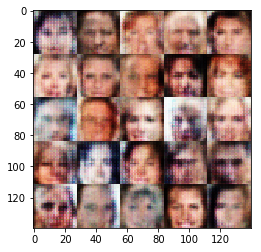

Epoch 0/1... Discriminator Loss: 0.7542... Generator Loss: 1.1553
Epoch 0/1... Discriminator Loss: 0.9696... Generator Loss: 1.2260
Epoch 0/1... Discriminator Loss: 0.7642... Generator Loss: 1.2746
Epoch 0/1... Discriminator Loss: 0.9142... Generator Loss: 0.8556
Epoch 0/1... Discriminator Loss: 1.0716... Generator Loss: 0.6731
Epoch 0/1... Discriminator Loss: 0.6942... Generator Loss: 1.2432
Epoch 0/1... Discriminator Loss: 1.0096... Generator Loss: 1.1418
Epoch 0/1... Discriminator Loss: 1.2552... Generator Loss: 1.2763
Epoch 0/1... Discriminator Loss: 0.8774... Generator Loss: 1.1925
Epoch 0/1... Discriminator Loss: 0.8662... Generator Loss: 1.1602


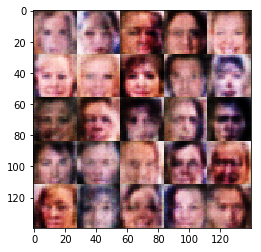

Epoch 0/1... Discriminator Loss: 1.0826... Generator Loss: 0.9631
Epoch 0/1... Discriminator Loss: 0.8825... Generator Loss: 1.2311
Epoch 0/1... Discriminator Loss: 0.9220... Generator Loss: 1.1131
Epoch 0/1... Discriminator Loss: 0.9189... Generator Loss: 1.0353
Epoch 0/1... Discriminator Loss: 1.1814... Generator Loss: 0.7370
Epoch 0/1... Discriminator Loss: 0.9006... Generator Loss: 1.0499
Epoch 0/1... Discriminator Loss: 0.8900... Generator Loss: 0.8643
Epoch 0/1... Discriminator Loss: 0.9896... Generator Loss: 0.8226
Epoch 0/1... Discriminator Loss: 0.9407... Generator Loss: 0.9604
Epoch 0/1... Discriminator Loss: 1.0126... Generator Loss: 0.9291


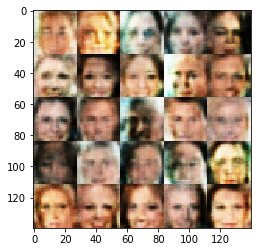

Epoch 0/1... Discriminator Loss: 1.0830... Generator Loss: 0.9203
Epoch 0/1... Discriminator Loss: 0.9080... Generator Loss: 1.2659
Epoch 0/1... Discriminator Loss: 0.8895... Generator Loss: 1.1478
Epoch 0/1... Discriminator Loss: 0.9462... Generator Loss: 0.8983
Epoch 0/1... Discriminator Loss: 0.9153... Generator Loss: 0.9444
Epoch 0/1... Discriminator Loss: 0.8717... Generator Loss: 1.3037
Epoch 0/1... Discriminator Loss: 0.9421... Generator Loss: 1.0714
Epoch 0/1... Discriminator Loss: 0.9250... Generator Loss: 1.0920
Epoch 0/1... Discriminator Loss: 1.0924... Generator Loss: 1.0449
Epoch 0/1... Discriminator Loss: 0.9482... Generator Loss: 1.1674


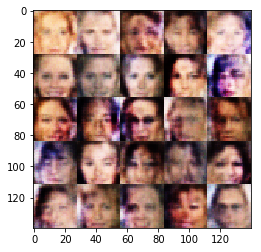

Epoch 0/1... Discriminator Loss: 0.8402... Generator Loss: 1.0155
Epoch 0/1... Discriminator Loss: 0.8724... Generator Loss: 1.1637
Epoch 0/1... Discriminator Loss: 1.0960... Generator Loss: 1.0448
Epoch 0/1... Discriminator Loss: 1.0721... Generator Loss: 1.0927
Epoch 0/1... Discriminator Loss: 1.0033... Generator Loss: 0.8076
Epoch 0/1... Discriminator Loss: 0.9125... Generator Loss: 0.9547
Epoch 0/1... Discriminator Loss: 0.8847... Generator Loss: 1.1062
Epoch 0/1... Discriminator Loss: 1.0942... Generator Loss: 0.8020
Epoch 0/1... Discriminator Loss: 0.9710... Generator Loss: 0.8603
Epoch 0/1... Discriminator Loss: 0.9966... Generator Loss: 0.7327


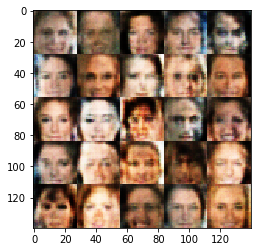

Epoch 0/1... Discriminator Loss: 0.9220... Generator Loss: 1.0533
Epoch 0/1... Discriminator Loss: 0.8102... Generator Loss: 1.1451
Epoch 0/1... Discriminator Loss: 0.9117... Generator Loss: 0.9735
Epoch 0/1... Discriminator Loss: 0.9464... Generator Loss: 0.8604
Epoch 0/1... Discriminator Loss: 0.9859... Generator Loss: 1.2288
Epoch 0/1... Discriminator Loss: 0.8289... Generator Loss: 1.1077
Epoch 0/1... Discriminator Loss: 0.8700... Generator Loss: 1.1766
Epoch 0/1... Discriminator Loss: 0.8906... Generator Loss: 0.9875
Epoch 0/1... Discriminator Loss: 0.9431... Generator Loss: 0.9914
Epoch 0/1... Discriminator Loss: 1.0613... Generator Loss: 0.6448


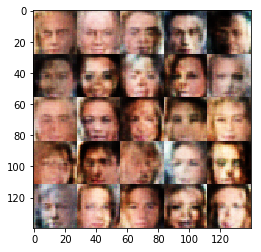

Epoch 0/1... Discriminator Loss: 0.9271... Generator Loss: 0.9283
Epoch 0/1... Discriminator Loss: 0.9894... Generator Loss: 0.8613
Epoch 0/1... Discriminator Loss: 0.9204... Generator Loss: 0.8812
Epoch 0/1... Discriminator Loss: 0.9632... Generator Loss: 0.8318
Epoch 0/1... Discriminator Loss: 1.0124... Generator Loss: 1.4179
Epoch 0/1... Discriminator Loss: 0.9755... Generator Loss: 0.8864
Epoch 0/1... Discriminator Loss: 0.9421... Generator Loss: 0.9274
Epoch 0/1... Discriminator Loss: 0.8353... Generator Loss: 1.1743
Epoch 0/1... Discriminator Loss: 1.0630... Generator Loss: 0.7830
Epoch 0/1... Discriminator Loss: 1.0076... Generator Loss: 0.9689


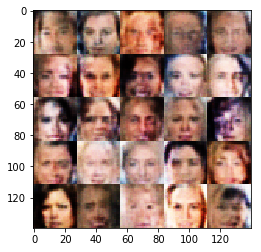

Epoch 0/1... Discriminator Loss: 0.9943... Generator Loss: 0.8903
Epoch 0/1... Discriminator Loss: 0.9991... Generator Loss: 1.0383
Epoch 0/1... Discriminator Loss: 0.8863... Generator Loss: 0.9084
Epoch 0/1... Discriminator Loss: 1.0271... Generator Loss: 0.9817
Epoch 0/1... Discriminator Loss: 0.9629... Generator Loss: 0.8230
Epoch 0/1... Discriminator Loss: 0.8762... Generator Loss: 1.1163
Epoch 0/1... Discriminator Loss: 0.8287... Generator Loss: 1.3559
Epoch 0/1... Discriminator Loss: 0.9854... Generator Loss: 1.0474
Epoch 0/1... Discriminator Loss: 0.8985... Generator Loss: 1.0705
Epoch 0/1... Discriminator Loss: 1.1008... Generator Loss: 0.6726


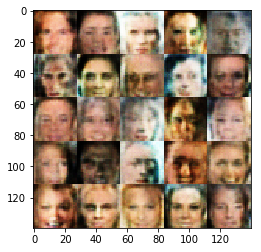

Epoch 0/1... Discriminator Loss: 0.9580... Generator Loss: 0.9527
Epoch 0/1... Discriminator Loss: 1.0796... Generator Loss: 1.0999
Epoch 0/1... Discriminator Loss: 0.9898... Generator Loss: 1.1068
Epoch 0/1... Discriminator Loss: 0.9449... Generator Loss: 1.1238
Epoch 0/1... Discriminator Loss: 0.8524... Generator Loss: 1.2674
Epoch 0/1... Discriminator Loss: 0.9341... Generator Loss: 1.0587
Epoch 0/1... Discriminator Loss: 1.0309... Generator Loss: 0.8626
Epoch 0/1... Discriminator Loss: 0.8995... Generator Loss: 1.0816
Epoch 0/1... Discriminator Loss: 1.0244... Generator Loss: 0.9156
Epoch 0/1... Discriminator Loss: 0.8697... Generator Loss: 1.1090


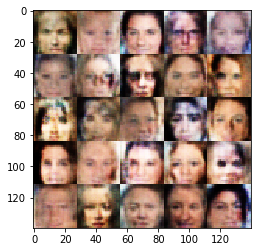

Epoch 0/1... Discriminator Loss: 0.9671... Generator Loss: 1.1118
Epoch 0/1... Discriminator Loss: 0.9839... Generator Loss: 0.8779
Epoch 0/1... Discriminator Loss: 1.1778... Generator Loss: 1.3982
Epoch 0/1... Discriminator Loss: 0.9512... Generator Loss: 1.2428
Epoch 0/1... Discriminator Loss: 0.9704... Generator Loss: 1.0190
Epoch 0/1... Discriminator Loss: 0.9699... Generator Loss: 0.8557
Epoch 0/1... Discriminator Loss: 0.9157... Generator Loss: 1.0040
Epoch 0/1... Discriminator Loss: 0.9489... Generator Loss: 0.8809
Epoch 0/1... Discriminator Loss: 1.0490... Generator Loss: 0.8535
Epoch 0/1... Discriminator Loss: 0.9893... Generator Loss: 0.8916


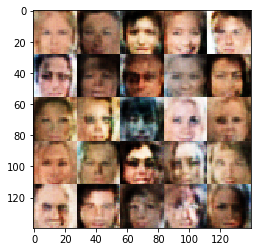

Epoch 0/1... Discriminator Loss: 0.7749... Generator Loss: 1.0876
Epoch 0/1... Discriminator Loss: 0.9425... Generator Loss: 1.1619
Epoch 0/1... Discriminator Loss: 1.0531... Generator Loss: 0.9010
Epoch 0/1... Discriminator Loss: 0.9525... Generator Loss: 0.8931
Epoch 0/1... Discriminator Loss: 0.8635... Generator Loss: 1.2931
Epoch 0/1... Discriminator Loss: 1.0445... Generator Loss: 0.7375
Epoch 0/1... Discriminator Loss: 0.9391... Generator Loss: 0.9447
Epoch 0/1... Discriminator Loss: 0.9706... Generator Loss: 1.5818
Epoch 0/1... Discriminator Loss: 0.9929... Generator Loss: 0.7538
Epoch 0/1... Discriminator Loss: 0.8501... Generator Loss: 1.5237


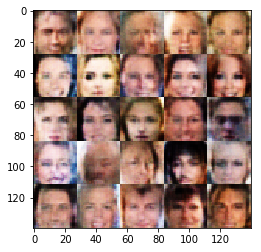

Epoch 0/1... Discriminator Loss: 0.9544... Generator Loss: 0.8541
Epoch 0/1... Discriminator Loss: 0.7795... Generator Loss: 1.3111
Epoch 0/1... Discriminator Loss: 0.9382... Generator Loss: 1.2366
Epoch 0/1... Discriminator Loss: 0.9026... Generator Loss: 1.1602
Epoch 0/1... Discriminator Loss: 0.8907... Generator Loss: 1.1380
Epoch 0/1... Discriminator Loss: 0.8244... Generator Loss: 1.0011
Epoch 0/1... Discriminator Loss: 0.9969... Generator Loss: 0.8729
Epoch 0/1... Discriminator Loss: 0.7520... Generator Loss: 1.1777
Epoch 0/1... Discriminator Loss: 0.8834... Generator Loss: 0.9422
Epoch 0/1... Discriminator Loss: 0.8877... Generator Loss: 0.9597


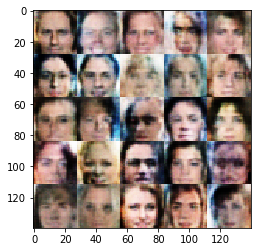

Epoch 0/1... Discriminator Loss: 1.2514... Generator Loss: 0.5080
Epoch 0/1... Discriminator Loss: 1.1675... Generator Loss: 0.8008
Epoch 0/1... Discriminator Loss: 1.1718... Generator Loss: 0.8137
Epoch 0/1... Discriminator Loss: 0.8497... Generator Loss: 0.9220
Epoch 0/1... Discriminator Loss: 0.9458... Generator Loss: 0.8709
Epoch 0/1... Discriminator Loss: 0.8076... Generator Loss: 1.2737
Epoch 0/1... Discriminator Loss: 0.6844... Generator Loss: 1.3223
Epoch 0/1... Discriminator Loss: 1.0299... Generator Loss: 0.7703
Epoch 0/1... Discriminator Loss: 1.1590... Generator Loss: 0.6054
Epoch 0/1... Discriminator Loss: 0.9792... Generator Loss: 1.4252


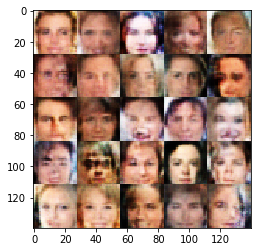

Epoch 0/1... Discriminator Loss: 0.8415... Generator Loss: 1.0897
Epoch 0/1... Discriminator Loss: 0.8530... Generator Loss: 1.0509
Epoch 0/1... Discriminator Loss: 1.0865... Generator Loss: 0.7509
Epoch 0/1... Discriminator Loss: 0.9589... Generator Loss: 1.0607
Epoch 0/1... Discriminator Loss: 1.0498... Generator Loss: 0.7122
Epoch 0/1... Discriminator Loss: 0.9643... Generator Loss: 0.9564
Epoch 0/1... Discriminator Loss: 0.9471... Generator Loss: 0.8525
Epoch 0/1... Discriminator Loss: 0.9400... Generator Loss: 0.9674
Epoch 0/1... Discriminator Loss: 0.9252... Generator Loss: 0.9316
Epoch 0/1... Discriminator Loss: 0.8037... Generator Loss: 1.1634


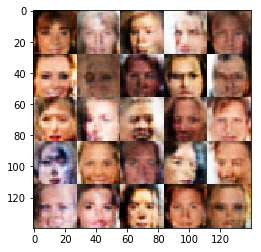

Epoch 0/1... Discriminator Loss: 0.9811... Generator Loss: 1.0208
Epoch 0/1... Discriminator Loss: 1.0466... Generator Loss: 0.6858
Epoch 0/1... Discriminator Loss: 0.7995... Generator Loss: 1.2328
Epoch 0/1... Discriminator Loss: 0.8763... Generator Loss: 1.2039
Epoch 0/1... Discriminator Loss: 1.0740... Generator Loss: 0.7086
Epoch 0/1... Discriminator Loss: 1.0842... Generator Loss: 0.7940
Epoch 0/1... Discriminator Loss: 0.9851... Generator Loss: 1.0916
Epoch 0/1... Discriminator Loss: 0.9824... Generator Loss: 0.9014
Epoch 0/1... Discriminator Loss: 1.0905... Generator Loss: 0.6473
Epoch 0/1... Discriminator Loss: 0.9224... Generator Loss: 1.0333


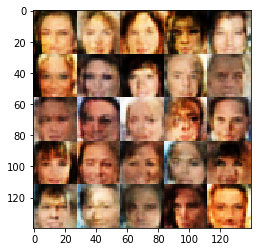

Epoch 0/1... Discriminator Loss: 0.9417... Generator Loss: 0.9758
Epoch 0/1... Discriminator Loss: 1.1898... Generator Loss: 0.6017
Epoch 0/1... Discriminator Loss: 1.0231... Generator Loss: 0.7708
Epoch 0/1... Discriminator Loss: 0.9408... Generator Loss: 0.8617
Epoch 0/1... Discriminator Loss: 0.9322... Generator Loss: 1.0309
Epoch 0/1... Discriminator Loss: 0.9035... Generator Loss: 0.9207
Epoch 0/1... Discriminator Loss: 1.0394... Generator Loss: 0.8628
Epoch 0/1... Discriminator Loss: 0.9458... Generator Loss: 0.9227
Epoch 0/1... Discriminator Loss: 1.0881... Generator Loss: 1.1092
Epoch 0/1... Discriminator Loss: 0.7024... Generator Loss: 1.3709


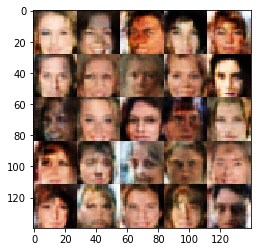

Epoch 0/1... Discriminator Loss: 1.0580... Generator Loss: 0.7658
Epoch 0/1... Discriminator Loss: 0.8322... Generator Loss: 1.0682
Epoch 0/1... Discriminator Loss: 0.8811... Generator Loss: 1.3103
Epoch 0/1... Discriminator Loss: 0.9359... Generator Loss: 1.2119
Epoch 0/1... Discriminator Loss: 0.9578... Generator Loss: 0.9216
Epoch 0/1... Discriminator Loss: 1.0296... Generator Loss: 0.8587
Epoch 0/1... Discriminator Loss: 0.8785... Generator Loss: 1.0357
Epoch 0/1... Discriminator Loss: 1.1207... Generator Loss: 0.6277
Epoch 0/1... Discriminator Loss: 1.0588... Generator Loss: 0.9147
Epoch 0/1... Discriminator Loss: 0.8433... Generator Loss: 1.0886


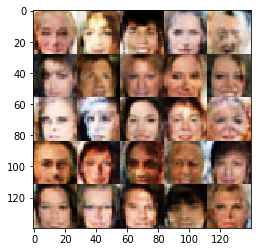

Epoch 0/1... Discriminator Loss: 0.9467... Generator Loss: 1.0770
Epoch 0/1... Discriminator Loss: 0.9855... Generator Loss: 1.3848
Epoch 0/1... Discriminator Loss: 0.9236... Generator Loss: 0.9522
Epoch 0/1... Discriminator Loss: 1.1846... Generator Loss: 0.5689
Epoch 0/1... Discriminator Loss: 1.0363... Generator Loss: 0.9024
Epoch 0/1... Discriminator Loss: 1.1369... Generator Loss: 0.6119
Epoch 0/1... Discriminator Loss: 0.7404... Generator Loss: 1.3500
Epoch 0/1... Discriminator Loss: 1.0773... Generator Loss: 0.9279
Epoch 0/1... Discriminator Loss: 0.9554... Generator Loss: 1.0475
Epoch 0/1... Discriminator Loss: 0.8837... Generator Loss: 1.0324


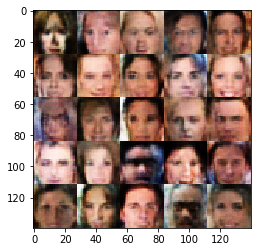

Epoch 0/1... Discriminator Loss: 0.9050... Generator Loss: 1.3862
Epoch 0/1... Discriminator Loss: 0.9911... Generator Loss: 0.7383
Epoch 0/1... Discriminator Loss: 1.0303... Generator Loss: 0.8582
Epoch 0/1... Discriminator Loss: 0.6936... Generator Loss: 1.5275
Epoch 0/1... Discriminator Loss: 1.2495... Generator Loss: 0.5296
Epoch 0/1... Discriminator Loss: 1.1201... Generator Loss: 1.7627
Epoch 0/1... Discriminator Loss: 0.8621... Generator Loss: 1.0767
Epoch 0/1... Discriminator Loss: 0.6512... Generator Loss: 1.2716
Epoch 0/1... Discriminator Loss: 0.8403... Generator Loss: 1.0998
Epoch 0/1... Discriminator Loss: 0.9521... Generator Loss: 0.8404


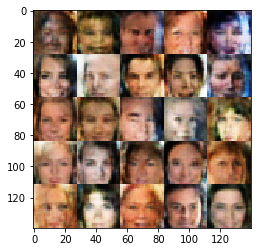

Epoch 0/1... Discriminator Loss: 0.9115... Generator Loss: 0.8421
Epoch 0/1... Discriminator Loss: 1.0426... Generator Loss: 0.6669
Epoch 0/1... Discriminator Loss: 0.8129... Generator Loss: 1.5766
Epoch 0/1... Discriminator Loss: 0.9172... Generator Loss: 1.1645
Epoch 0/1... Discriminator Loss: 0.9192... Generator Loss: 0.8805
Epoch 0/1... Discriminator Loss: 0.8587... Generator Loss: 1.4782
Epoch 0/1... Discriminator Loss: 1.0142... Generator Loss: 0.7101
Epoch 0/1... Discriminator Loss: 1.0247... Generator Loss: 0.7917
Epoch 0/1... Discriminator Loss: 1.0381... Generator Loss: 0.8096
Epoch 0/1... Discriminator Loss: 0.8529... Generator Loss: 0.8675


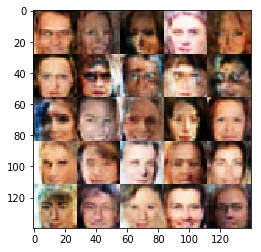

Epoch 0/1... Discriminator Loss: 0.9741... Generator Loss: 0.8099
Epoch 0/1... Discriminator Loss: 0.9497... Generator Loss: 1.0686
Epoch 0/1... Discriminator Loss: 1.1598... Generator Loss: 0.8784
Epoch 0/1... Discriminator Loss: 0.8197... Generator Loss: 1.1055
Epoch 0/1... Discriminator Loss: 0.8284... Generator Loss: 1.3657
Epoch 0/1... Discriminator Loss: 0.8825... Generator Loss: 1.0320
Epoch 0/1... Discriminator Loss: 0.8632... Generator Loss: 1.1808
Epoch 0/1... Discriminator Loss: 0.9356... Generator Loss: 0.9027
Epoch 0/1... Discriminator Loss: 0.8481... Generator Loss: 1.0679
Epoch 0/1... Discriminator Loss: 0.9921... Generator Loss: 0.9464


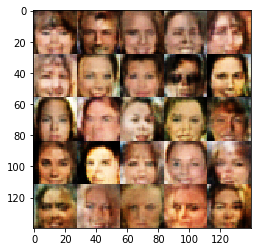

Epoch 0/1... Discriminator Loss: 0.9262... Generator Loss: 1.2900
Epoch 0/1... Discriminator Loss: 0.9497... Generator Loss: 0.8816
Epoch 0/1... Discriminator Loss: 1.1950... Generator Loss: 0.5749
Epoch 0/1... Discriminator Loss: 1.0591... Generator Loss: 0.8191
Epoch 0/1... Discriminator Loss: 1.1278... Generator Loss: 1.0825
Epoch 0/1... Discriminator Loss: 0.9028... Generator Loss: 1.5680
Epoch 0/1... Discriminator Loss: 0.9204... Generator Loss: 1.2263
Epoch 0/1... Discriminator Loss: 0.9640... Generator Loss: 0.8910
Epoch 0/1... Discriminator Loss: 1.0293... Generator Loss: 0.7881
Epoch 0/1... Discriminator Loss: 1.0109... Generator Loss: 0.9486


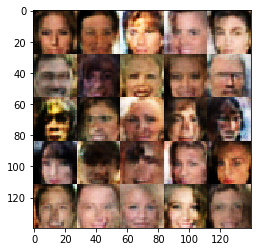

Epoch 0/1... Discriminator Loss: 0.8183... Generator Loss: 1.0738
Epoch 0/1... Discriminator Loss: 0.8038... Generator Loss: 1.3770
Epoch 0/1... Discriminator Loss: 0.9681... Generator Loss: 0.9457
Epoch 0/1... Discriminator Loss: 1.0042... Generator Loss: 0.8321
Epoch 0/1... Discriminator Loss: 0.8490... Generator Loss: 0.9502
Epoch 0/1... Discriminator Loss: 0.9524... Generator Loss: 0.7543
Epoch 0/1... Discriminator Loss: 0.9806... Generator Loss: 0.7481
Epoch 0/1... Discriminator Loss: 0.7600... Generator Loss: 1.1737
Epoch 0/1... Discriminator Loss: 1.0114... Generator Loss: 0.8778
Epoch 0/1... Discriminator Loss: 1.1698... Generator Loss: 0.6545


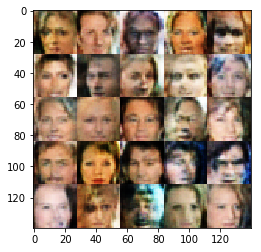

Epoch 0/1... Discriminator Loss: 1.0004... Generator Loss: 1.0071
Epoch 0/1... Discriminator Loss: 1.0156... Generator Loss: 0.8026
Epoch 0/1... Discriminator Loss: 0.8643... Generator Loss: 1.1455
Epoch 0/1... Discriminator Loss: 1.0075... Generator Loss: 0.8076
Epoch 0/1... Discriminator Loss: 0.8906... Generator Loss: 1.3019
Epoch 0/1... Discriminator Loss: 0.8469... Generator Loss: 0.9834
Epoch 0/1... Discriminator Loss: 1.0978... Generator Loss: 0.6275
Epoch 0/1... Discriminator Loss: 0.9240... Generator Loss: 0.8391
Epoch 0/1... Discriminator Loss: 0.8718... Generator Loss: 1.1209
Epoch 0/1... Discriminator Loss: 0.9254... Generator Loss: 0.9273


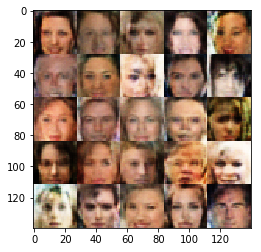

Epoch 0/1... Discriminator Loss: 0.8026... Generator Loss: 1.1157
Epoch 0/1... Discriminator Loss: 0.9399... Generator Loss: 1.0313
Epoch 0/1... Discriminator Loss: 1.0877... Generator Loss: 0.6775
Epoch 0/1... Discriminator Loss: 0.7688... Generator Loss: 1.0254
Epoch 0/1... Discriminator Loss: 1.0095... Generator Loss: 0.8733
Epoch 0/1... Discriminator Loss: 1.0574... Generator Loss: 0.9072


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.